# Limpieza de Dataset DMR-IR

Eliminación de IDs corruptos del split de test.

In [70]:
from datasets import load_dataset, DatasetDict

# Cargar el dataset original
dataset = load_dataset("SemilleroCV/DMR-IR")
print(f"Dataset cargado con {len(dataset['train'])} ejemplos de entrenamiento y {len(dataset['test'])} ejemplos de prueba")

Dataset cargado con 5671 ejemplos de entrenamiento y 1482 ejemplos de prueba


In [71]:
# Ver un ejemplo para confirmar la estructura
example = dataset['test'][0]
print(f"Campos disponibles: {list(example.keys())}")
print(f"Etiqueta: {example['label']}")
print(f"Texto: {example['text'][:100]}...")

Campos disponibles: ['image', 'label', 'text']
Etiqueta: 0
Texto: Patient is 78 years old of mestizo race. Has eating habits fatty diet. Complaints reported were no. ...


In [72]:
# Cargar los IDs corruptos desde el archivo
with open("../data/dmrir_defective_test.txt", "r") as f:
    test_corrupted_ids = [int(line.strip()) for line in f if line.strip() and not line.startswith("//")]

with open("../data/dmrir_defective_train.txt", "r") as f:
    train_corrupted_ids = [int(line.strip()) for line in f if line.strip() and not line.startswith("//")]


print(f"Se encontraron {len(test_corrupted_ids)} IDs corruptos en el conjunto de prueba y {len(train_corrupted_ids)} en el de entrenamiento")
print(f"Primeros 5 IDs corruptos: {test_corrupted_ids[:5]} y {train_corrupted_ids[:5]}")
print(f"Últimos 5 IDs corruptos: {test_corrupted_ids[-5:]} y {train_corrupted_ids[-5:]}")

Se encontraron 12 IDs corruptos en el conjunto de prueba y 8 en el de entrenamiento
Primeros 5 IDs corruptos: [678, 679, 680, 681, 682] y [1417, 1418, 1419, 1420, 1421]
Últimos 5 IDs corruptos: [685, 686, 687, 688, 689] y [1420, 1421, 4068, 4168, 4196]


Displaying 12 potentially corrupted images in 1 batches

Displaying batch 1/1 (IDs 0-11)


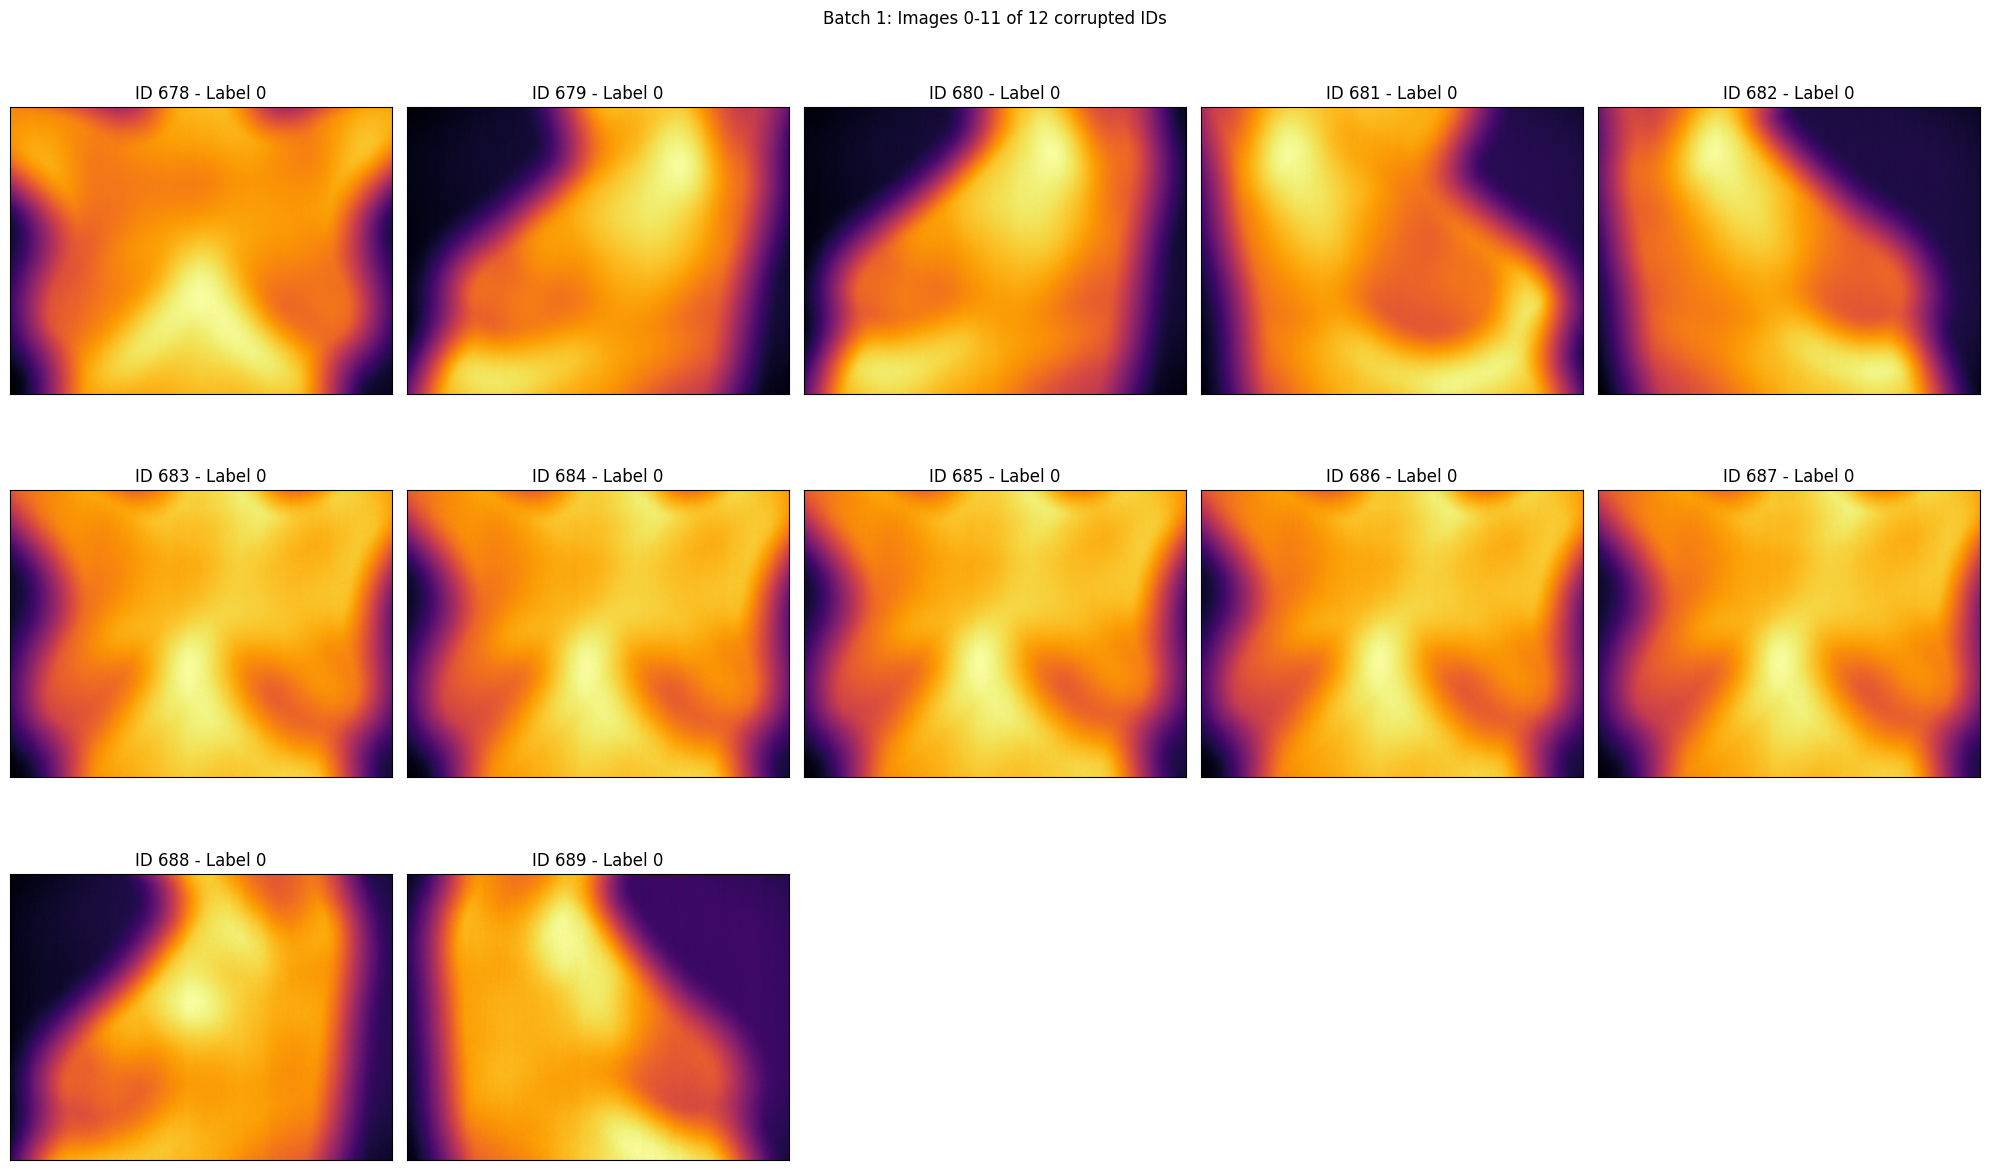

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import math

def display_image_batch(dataset, id_list, batch_start, batch_size):
    """
    Display a batch of images from the dataset.
    
    Args:
        dataset: The dataset containing the images
        id_list: List of IDs to display
        batch_start: Starting index in id_list
        batch_size: Number of images to display in this batch
    """
    # Get the actual IDs for this batch
    batch_ids = id_list[batch_start:batch_start+batch_size]
    actual_batch_size = len(batch_ids)
    
    # Calculate grid dimensions (trying to make it roughly square)
    grid_cols = min(5, actual_batch_size)
    grid_rows = math.ceil(actual_batch_size / grid_cols)
    
    # Create figure
    plt.figure(figsize=(grid_cols * 4, grid_rows * 4))
    
    for i, idx in enumerate(batch_ids):
        plt.subplot(grid_rows, grid_cols, i+1)
        
        try:
            if idx < len(dataset['test']):
                example = dataset['test'][idx]
                img_pil = example['image']
                img = np.array(img_pil, dtype=np.float32)
                plt.imshow(img, cmap='inferno')
                plt.title(f"ID {idx} - Label {example['label']}")
            else:
                plt.text(0.5, 0.5, f"ID {idx} - Out of range", 
                         ha='center', va='center')
                plt.axis('off')
        except Exception as e:
            plt.text(0.5, 0.5, f"ID {idx} - Error: {str(e)[:20]}...", 
                     ha='center', va='center', wrap=True)
            plt.axis('off')
            
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.suptitle(f"Batch {batch_start//batch_size + 1}: Images {batch_start}-{batch_start+actual_batch_size-1} of {len(id_list)} corrupted IDs", 
                y=1.02)
    plt.show()

# Display all corrupted images in batches of 20
batch_size = 20
num_batches = math.ceil(len(corrupted_ids) / batch_size)

print(f"Displaying {len(corrupted_ids)} potentially corrupted images in {num_batches} batches")

for batch in range(num_batches):
    batch_start = batch * batch_size
    print(f"\nDisplaying batch {batch+1}/{num_batches} (IDs {batch_start}-{min(batch_start+batch_size-1, len(corrupted_ids)-1)})")
    display_image_batch(dataset, corrupted_ids, batch_start, batch_size)

In [73]:
# Filtrar el conjunto de test para eliminar los IDs corruptos
test_ds = dataset['test']
test_valid_indices = [i for i in range(len(test_ds)) if i not in test_corrupted_ids]

train_ds = dataset['train']
train_valid_indices = [i for i in range(len(train_ds)) if i not in train_corrupted_ids]

print(f"Total de ejemplos en test original: {len(test_ds)}")
print(f"Total de ejemplos válidos después de filtrar: {len(test_valid_indices)}")

print(f"Total de ejemplos en train original: {len(train_ds)}")
print(f"Total de ejemplos válidos después de filtrar: {len(train_valid_indices)}")

# Crear nuevo dataset sin ejemplos corruptos
filtered_test = test_ds.select(test_valid_indices)
filtered_train = train_ds.select(train_valid_indices)

Total de ejemplos en test original: 1482
Total de ejemplos válidos después de filtrar: 1470
Total de ejemplos en train original: 5671
Total de ejemplos válidos después de filtrar: 5663


In [74]:
# Crear el DatasetDict final y guardarlo
filtered_dataset = DatasetDict({
    'train': filtered_train,
    'test': filtered_test
})

print(f"Dataset limpio: {len(filtered_dataset['train'])} ejemplos de entrenamiento, {len(filtered_dataset['test'])} ejemplos de prueba")

Dataset limpio: 5663 ejemplos de entrenamiento, 1470 ejemplos de prueba


In [75]:
# Guardar el dataset limpio
output_path = "../data/DMR-IR-cleaned"
filtered_dataset.save_to_disk(output_path)
print(f"Dataset guardado en {output_path}")

Saving the dataset (4/4 shards): 100%|██████████| 1470/1470 [00:08<00:00, 168.23 examples/s]

Dataset guardado en ../data/DMR-IR-cleaned


In [77]:
from datasets import load_from_disk

repository_id = "SemilleroCV/DMR-IR"
cleaned_dataset = load_from_disk(output_path)

In [78]:
# To update an existing dataset
cleaned_dataset.push_to_hub(
    repository_id,
    private=True,
    embed_external_files=True,
    commit_message="Updated cleaned dataset with additional fixes",
)

Uploading the dataset shards: 100%|██████████| 4/4 [01:45<00:00, 26.49s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/SemilleroCV/DMR-IR/commit/69ffd6240b4a50bc4a05c59b70773f3a506054f2', commit_message='Updated cleaned dataset with additional fixes', commit_description='', oid='69ffd6240b4a50bc4a05c59b70773f3a506054f2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/SemilleroCV/DMR-IR', endpoint='https://huggingface.co', repo_type='dataset', repo_id='SemilleroCV/DMR-IR'), pr_revision=None, pr_num=None)

In [1]:
from datasets import load_dataset

# Cargar el dataset original
dataset = load_dataset("SemilleroCV/DMR-IR")
print(f"Dataset cargado con {len(dataset['train'])} ejemplos de entrenamiento y {len(dataset['test'])} ejemplos de prueba")

/home/sara/miniconda3/envs/colcaci/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Error while downloading from https://cdn-lfs-us-1.hf.co/repos/86/93/8693d53a95e28870702a280d6381db6b8c69af7fadf136ab6a11390de1ec1472/41adddbee3fa7a7be9c2b3c0bf4c7a64f8838feb9a29a2a4c92c763a8c928dbc?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27train-00001-of-00014.parquet%3B+filename%3D%22train-00001-of-00014.parquet%22%3B&Expires=1745976391&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NTk3NjM5MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzg2LzkzLzg2OTNkNTNhOTVlMjg4NzA3MDJhMjgwZDYzODFkYjZiOGM2OWFmN2ZhZGYxMzZhYjZhMTEzOTBkZTFlYzE0NzIvNDFhZGRkYmVlM2ZhN2E3YmU5YzJiM2MwYmY0YzdhNjRmODgzOGZlYjlhMjlhMmE0YzkyYzc2M2E4YzkyOGRiYz9yZXNwb25zZS1jb250ZW50LWRp

KeyboardInterrupt: 